In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr

In [2]:
import xesmf as xe
import importlib
importlib.reload(xe)

<module 'xesmf' from '/Users/zhuangjw/Research/Computing/ESMPy-xarray/xESMF/xesmf/__init__.py'>

# Make grids

In [3]:
ds_in = xe.util.grid_global(5, 4)
ds_out = xe.util.grid_global(2, 2)
ds_out

<xarray.Dataset>
Dimensions:  (x: 180, x_b: 181, y: 90, y_b: 91)
Coordinates:
    lon      (y, x) float64 -179.0 -177.0 -175.0 -173.0 -171.0 -169.0 -167.0 ...
    lat      (y, x) float64 -89.0 -89.0 -89.0 -89.0 -89.0 -89.0 -89.0 -89.0 ...
    lon_b    (y_b, x_b) int64 -180 -178 -176 -174 -172 -170 -168 -166 -164 ...
    lat_b    (y_b, x_b) int64 -90 -90 -90 -90 -90 -90 -90 -90 -90 -90 -90 ...
Dimensions without coordinates: x, x_b, y, y_b
Data variables:
    *empty*

# Build regridder

In [4]:
#regridder = xe.Regridder(ds_in.rename(dict(x='x_new')), 
#                         ds_out.rename(dict(x='x_new')), 
#                         'conservative', reuse_weights=True)

In [5]:
regridder = xe.Regridder(ds_in, ds_out, 
                         'conservative', reuse_weights=True)

Reuse existing file: conservative_45x72_90x180.nc


In [6]:
regridder

xESMF Regridder 
Regridding algorithm:       conservative 
Weight filename:            conservative_45x72_90x180.nc 
Reuse pre-computed weights? True 
Input grid shape:           (45, 72) 
Output grid shape:          (90, 180) 
Grid dimension name:        ('y', 'x') 
Boundary dimension name:    ('y_b', 'x_b') 

# Regrid 2D data

In [7]:
ds_in['data'] = xe.data.wave_smooth(ds_in['lon'], ds_in['lat'])

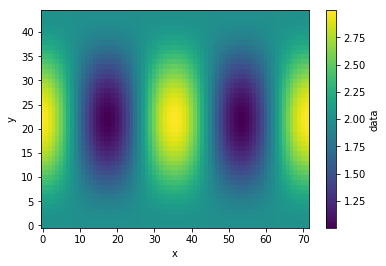

In [8]:
ds_in['data'].plot()

In [9]:
dr_out = regridder(ds_in['data'])
dr_out

<xarray.DataArray 'data' (y: 90, x: 180)>
array([[ 2.001213,  2.001213,  2.001195, ...,  2.001195,  2.001213,  2.001213],
       [ 2.001225,  2.001233,  2.001201, ...,  2.001201,  2.001233,  2.001225],
       [ 2.010885,  2.010885,  2.010719, ...,  2.010719,  2.010885,  2.010885],
       ..., 
       [ 2.010885,  2.010885,  2.010719, ...,  2.010719,  2.010885,  2.010885],
       [ 2.001225,  2.001233,  2.001201, ...,  2.001201,  2.001233,  2.001225],
       [ 2.001213,  2.001213,  2.001195, ...,  2.001195,  2.001213,  2.001213]])
Coordinates:
    lon      (y, x) float64 -179.0 -177.0 -175.0 -173.0 -171.0 -169.0 -167.0 ...
    lat      (y, x) float64 -89.0 -89.0 -89.0 -89.0 -89.0 -89.0 -89.0 -89.0 ...
Dimensions without coordinates: y, x

In [10]:
np.testing.assert_array_equal(dr_out['lon'], ds_out['lon'] )
np.testing.assert_array_equal(dr_out['lat'], ds_out['lat'] )

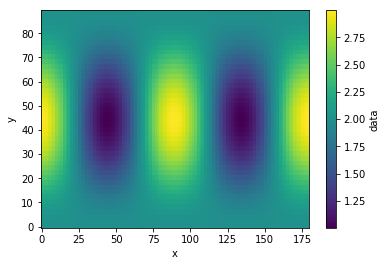

In [11]:
dr_out.plot()

# Broadcast

In [12]:
extra_dims = [50, 10] # lev, time
ds_in.coords['time'] = np.arange(1, extra_dims[1]+1)
ds_in.coords['lev'] = np.arange(1, extra_dims[0]+1)
ds_in['data4D'] = ds_in['time'] * ds_in['lev'] * ds_in['data']

In [13]:
ds_in['data4D'].shape

(10, 50, 45, 72)

In [14]:
%time dr_out_4D = regridder(ds_in['data4D'])

CPU times: user 36.9 ms, sys: 19.9 ms, total: 56.8 ms
Wall time: 56.3 ms


In [15]:
xr.testing.assert_identical(dr_out_4D['time'], ds_in['time'])
xr.testing.assert_identical(dr_out_4D['lev'], ds_in['lev'])

In [16]:
dr_out_4D

<xarray.DataArray 'data4D' (time: 10, lev: 50, y: 90, x: 180)>
array([[[[    2.001213, ...,     2.001213],
         ..., 
         [    2.001213, ...,     2.001213]],

        ..., 
        [[  100.060667, ...,   100.060667],
         ..., 
         [  100.060667, ...,   100.060667]]],


       ..., 
       [[[   20.012133, ...,    20.012133],
         ..., 
         [   20.012133, ...,    20.012133]],

        ..., 
        [[ 1000.60667 , ...,  1000.60667 ],
         ..., 
         [ 1000.60667 , ...,  1000.60667 ]]]])
Coordinates:
    lon      (y, x) float64 -179.0 -177.0 -175.0 -173.0 -171.0 -169.0 -167.0 ...
    lat      (y, x) float64 -89.0 -89.0 -89.0 -89.0 -89.0 -89.0 -89.0 -89.0 ...
  * time     (time) int64 1 2 3 4 5 6 7 8 9 10
  * lev      (lev) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
Dimensions without coordinates: y, x

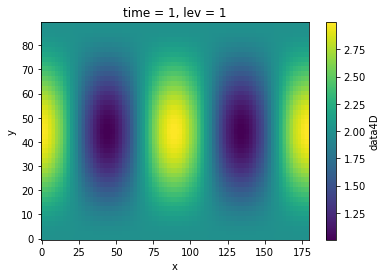

In [17]:
dr_out_4D.isel(time=0, lev=0).plot()

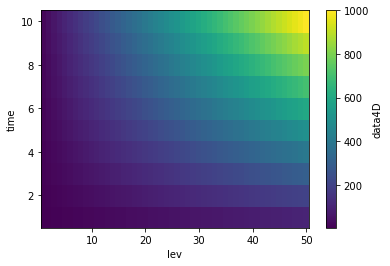

In [18]:
dr_out_4D.mean(dim=['x','y']).plot()